This notebook compares two methods of computing a similarity score between reactions.

**1. Reaction Center Maximum Common Subgraph (RCMCS)** finds the largest shared subgraph between reaction graphs that also contains the reaction center (RC) of both reactions. I.e., the RCMCS of two reactions with distinct reaction centers is the null set. To compute a number for the similarity score, one can divide the size of the RCMCS by the size of either of the two reaction graphs.

**2. Reaction Center Morgan fingerprint (RCMFP)** first gets a bit vector for each reaction and then uses Tanimoto similarity of the fingerprints. We recommend using minimum topological distance to the reaction center as an atom feature for best results. Additionally, if your application requires, it is simple to enforce the rule that only reactions with equivalent reaction center get non-zero similarity scores, as is the case with RCMCS. See the helper function `rcmfp_S` below for an example.

RCMCS is excellent for predicting Enzyme Commission (EC) numbers [Pate et al., 2026](https://www.biorxiv.org/content/10.1101/2025.06.22.660952v2). However, it is very slow to compute as shown below. We developed RCMFP to be a faster, but still effective, alternative.

In [1]:
from ergochemics.mapping import get_reaction_center
from ergochemics.similarity import ReactionFingerprinter, rcmcs_similarity, MolFeaturizer
from rdkit import Chem
import pandas as pd
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
import json

Load atom-mapped reactions for demonstration. This data was sourced from [this repository](https://github.com/stefanpate/enz-rxn-data/tree/main/src/enz_rxn_data) which pulls from [Rhea](https://www.rhea-db.org/) and [UniProt](https://www.uniprot.org/).

In [ ]:
maps = pd.read_parquet("mapped_known_reactions_x_rc_plus_0_rules.parquet")
maps['sma_len'] = maps['smarts'].apply(lambda x: len(x))
maps = maps[maps['sma_len'] < 30] # Keep in mind this is best case; actual scaling will be worse
print(f"Number of reactions to process: {len(maps)}")
maps.head()

Number of reactions to process: 272


,rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id,sma_len
0,4fc554b86bb64504ce3bb78f4c02accc82779129,*C#N.O>>*C(N)=O,[*:4][C:2]#[N:1].[OH2:3]>>[*:4][C:2]([NH2:1])=...,[#6:1]#[#7:2].[#8:3]>>[#7:2]-[#6:1]=[#8:3],"1,2;0>>1,2,3",549,15
1,4fe435c487c7b2dc720dff02a9af2d54cebd191a,*C#N.O>>*C=NO,[*:4][C:1]#[N:2].[OH2:3]>>[*:4][CH:1]=[N:2][OH:3],[#6:1]#[#7:2].[#8:3]>>[#6:1]=[#7:2]-[#8:3],"1,2;0>>1,2,3",785,13
533,cc88b99142b29da5389a0a776023f7b183604711,*C(=O)NCCO.O>>*C(=O)O.NCCO,[*:3][C:1](=[O:4])[NH:5][CH2:6][CH2:7][OH:8].[...,[#6:1]-[#7:2].[#8:3]>>[#6:1]-[#8:3].[#7:2],"1,3;0>>1,3;0",587,26
554,d36074b61c3e5a0b03ea54d7baca0b7bfd8af489,*C(=O)O.*O>>*OC(*)=O.O,[*:3][C:1](=[O:4])[OH:6].[*:5][OH:2]>>[*:5][O:...,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],"1,3;1>>1,2;0",517,22
577,552c270a8b0a95ecfa186b5f781a305b52e3b92f,*C(=O)O.CCO>>*C(=O)OCC.O,[*:3][C:1](=[O:4])[OH:7].[CH3:6][CH2:5][OH:2]>...,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],"1,3;2>>1,3;0",517,24


Define several helper functions.

In [13]:
def get_rc_patts(am_rxn: str) -> tuple[str, str]:
    ''' Get reaction center pattern SMILES (left and right) from an atom-mapped reaction.'''
    lrc_idx, rrc_idx = get_reaction_center(am_rxn, mode="combined")
    lhs, rhs = [Chem.MolFromSmiles(smi) for smi in am_rxn.split(">>")]

    for mol in [lhs, rhs]:
        for atom in mol.GetAtoms():
            atom.SetAtomMapNum(0)

    lrc = Chem.MolFragmentToSmiles(lhs, lrc_idx)
    rrc = Chem.MolFragmentToSmiles(rhs, rrc_idx)
    return (lrc, rrc)

def tani_sim(X1: np.ndarray, X2: np.ndarray) -> np.ndarray:
    ''' Compute Tanimoto similarity between two sets of fingerprints.'''
    A = X1 @ X2.T
    norms1 = X1.sum(axis=1).reshape(-1, 1)
    norms2 = X2.sum(axis=1).reshape(1, -1)
    N = norms1 + norms2
    S = A / (N - A)
    return S

def rcmfp_S(df: pd.DataFrame, use_rc: bool, filter_by_rc: bool) -> np.ndarray:
    ''' 
    Compute RCMFP similarity matrix for all pairs in the dataframe.
    
    Args
    ----
    df: pd.DataFrame
        DataFrame containing the reactions with 'am_smarts' column.
    use_rc: bool
        Whether to use reaction center information in fingerprinting.
    filter_by_rc: bool
        Whether to filter similarity scores by reaction center patterns.

    Returns
    -------
    np.ndarray
        Similarity matrix.
    '''
    idx_to_rc_patt = {}
    rxnfps = []
    rxn_fper = ReactionFingerprinter(
        radius=2,
        length=2048,
        mol_featurizer=MolFeaturizer(),
    )
    i = 0
    for _, row in df.iterrows():
        smi = row['am_smarts']
        rc_patt = get_rc_patts(smi)
        idx_to_rc_patt[i] = rc_patt
        fp = rxn_fper.fingerprint(smi, use_rc=use_rc)
        rxnfps.append(fp)
        i += 1

    rxnfps = np.vstack(rxnfps).astype(np.float32)
    d = rxnfps.shape[1]
    rxnfps_rev = np.concatenate([rxnfps[:, d//2:], rxnfps[:, :d//2]], axis=1)
    S1 = tani_sim(rxnfps, rxnfps)
    S2 = tani_sim(rxnfps, rxnfps_rev)
    S = np.maximum(S1, S2)

    if filter_by_rc:
        filtered_S = np.zeros_like(S)
        for i in range(len(idx_to_rc_patt)):
            for j in range(i, len(idx_to_rc_patt)):
                patt_i = idx_to_rc_patt[i]
                patt_j = idx_to_rc_patt[j]
                if patt_i == patt_j:
                    filtered_S[i, j] = S[i, j]
                    continue

                if tuple(reversed(patt_i)) == patt_j:
                    filtered_S[i, j] = S[i, j]
                    continue

        return filtered_S
    else:
        return S

def rcmfp_sim_for_set(df: pd.DataFrame, use_rc: bool, filter_by_rc: bool) -> tuple[list[float], float]:
    ''' Compute RCMFP similarity for all pairs in the dataframe.'''
    start = perf_counter()
    S = rcmfp_S(df, use_rc=use_rc, filter_by_rc=filter_by_rc)
    idx = np.triu_indices(S.shape[0])
    scores = S[idx].ravel().tolist()
    duration = perf_counter() - start
    return scores, duration

def rcmcs_sim_for_set(df: pd.DataFrame) -> tuple[list[float], float]:
    ''' Compute RCMCS similarity for all pairs in the dataframe.'''
    rcmcs_scores = []
    nrows = df.shape[0]
    am_smarts_list = df["am_smarts"].tolist()
    start = perf_counter()
    for i in range(nrows):
        for j in range(i, nrows):
            smi1 = am_smarts_list[i]
            smi2 = am_smarts_list[j]
            score = rcmcs_similarity(smi1, smi2)
            rcmcs_scores.append(score)

    duration = perf_counter() - start
    return rcmcs_scores, duration

def get_top_knn(sim_mat: np.ndarray, top_k: int) -> dict[int, list[int]]:
    ''' Get top-k nearest neighbors from similarity matrix.'''
    knn_dict = {}
    for i in range(sim_mat.shape[0]):
        knn_idx = np.argsort(-sim_mat[i, :])[:top_k + 1]
        knn_idx = knn_idx[knn_idx != i]
        knn_dict[i] = knn_idx.tolist()
    return knn_dict

def compare_ecs(ec_set_1: set[tuple[str, str, str, str]], ec_set_2: set[tuple[str, str, str, str]], level: int) -> bool:
    ''' Compare two sets of EC numbers at a given level.'''
    _ec_set_1 = {ec_tuple[:level] for ec_tuple in ec_set_1}
    _ec_set_2 = {ec_tuple[:level] for ec_tuple in ec_set_2}
    return len(_ec_set_1.intersection(_ec_set_2)) > 0

def top_k_accuracy(knn_dict: dict[int, list[int]], idx2ec: dict[int, set[tuple[str, str, str, str]]], level: int) -> float:
    ''' Compute top-k accuracy based on EC number comparison.'''
    correct = 0
    total = 0
    for idx, neighbors in knn_dict.items():
        if idx not in idx2ec:
            continue
        total += 1
        ec_set = idx2ec[idx]
        found = False
        for neighbor in neighbors:
            if neighbor not in idx2ec:
                continue
            neighbor_ec_set = idx2ec[neighbor]
            if compare_ecs(ec_set, neighbor_ec_set, level):
                found = True
                break
        if found:
            correct += 1
    return correct / total


In [4]:
ns = [2, 4, 8, 16, 32, 64, 128]
rcmcs_durations = []
rcmfp_durations = []
rcmfp_w_filtering_durations = []
for n in ns:
    print(f"Processing {n} reactions...")
    df = maps.sample(n, random_state=42)
    rcmcs_scores, rcmcs_duration = rcmcs_sim_for_set(df)
    rcmfp_scores, rcmfp_duration = rcmfp_sim_for_set(df, use_rc=True, filter_by_rc=False)
    filtered_rcmfp_scores, rcmfp_w_filtering_duration = rcmfp_sim_for_set(df, use_rc=True, filter_by_rc=True)
    mfp_scores, _ = rcmfp_sim_for_set(df, use_rc=False, filter_by_rc=False)
    rcmcs_durations.append(rcmcs_duration)
    rcmfp_durations.append(rcmfp_duration)
    rcmfp_w_filtering_durations.append(rcmfp_w_filtering_duration)

Processing 2 reactions...
Processing 4 reactions...
Processing 8 reactions...
Processing 16 reactions...
Processing 32 reactions...
Processing 64 reactions...
Processing 128 reactions...


The below plot shows that RCMFP scales much better than RCMCS, even if you elect to filter scores by enforcing that reactions with different RCs get a similarity score of zero.

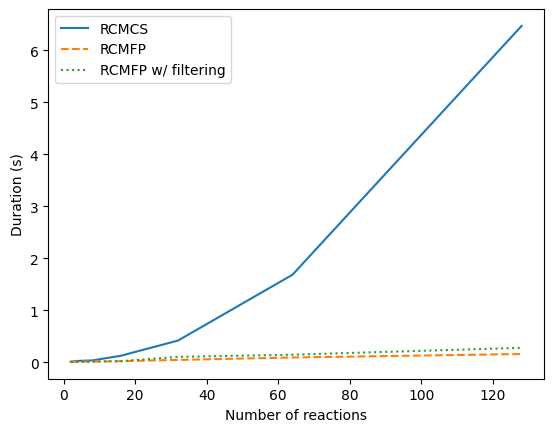

In [5]:
fig, ax = plt.subplots()
ax.plot(ns, rcmcs_durations, label="RCMCS")
ax.plot(ns, rcmfp_durations, label="RCMFP", ls='--')
ax.plot(ns, rcmfp_w_filtering_durations, label="RCMFP w/ filtering", ls=':')
ax.set_xlabel("Number of reactions")
ax.set_ylabel("Duration (s)")
ax.legend()
plt.show()

The below figure shows parity plots between each of the MFP-based simialrity metrics and RCMCS. RCMFP w/ filtering achieves the best parity by squashing the scatter on the far left-hand side to zero because of mismatched RCs.

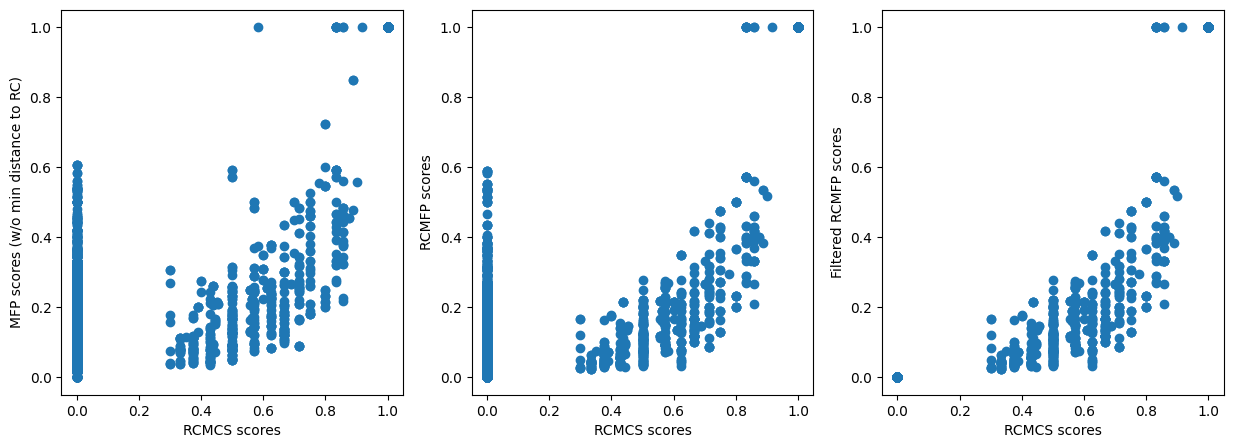

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].plot(rcmcs_scores, mfp_scores, 'o')
ax[0].set_xlabel("RCMCS scores")
ax[0].set_ylabel("MFP scores (w/o min distance to RC)")
ax[1].plot(rcmcs_scores, rcmfp_scores, 'o')
ax[1].set_xlabel("RCMCS scores")
ax[1].set_ylabel("RCMFP scores")
ax[2].plot(rcmcs_scores, filtered_rcmfp_scores, 'o')
ax[2].set_xlabel("RCMCS scores")
ax[2].set_ylabel("Filtered RCMFP scores")
plt.show()

Load data and perform leave-one-out EC number classification.

In [7]:
toc = pd.read_csv(
    "v3_folded_pt_ns.csv",
    sep='\t'
)
feature_idx = {}
for i, elt in enumerate(toc.index):
            labels = toc.loc[elt, 'Label'].split(';')
            for label in labels:
                if label in feature_idx:
                    j = feature_idx[label]
                else:
                    j = len(feature_idx)
                    feature_idx[label] = j

rid2idx = {int(k): v for k, v in feature_idx.items()}

with open("v3_folded_pt_ns.json", 'r') as f:
    tmp = json.load(f)
    rxn_details = {int(k): v for k, v in tmp.items()}
    del tmp

# Map all stable rhea ids at 250915 to single unique idx for convernience
rhea_directions = pd.read_csv('rhea-directions.tsv', sep='\t')
any_rhea_to_working_idx = {}
for i, row in rhea_directions.iterrows():
    any_rhea_to_working_idx[row['RHEA_ID_MASTER']] = i
    any_rhea_to_working_idx[row['RHEA_ID_LR']] = i
    any_rhea_to_working_idx[row['RHEA_ID_RL']] = i
    any_rhea_to_working_idx[row['RHEA_ID_BI']] = i

rhea2ec = pd.read_csv('rhea2ec.tsv', sep='\t')
rhea2ec = {any_rhea_to_working_idx[row['RHEA_ID']]: row['ID'] for i, row in rhea2ec.iterrows() if row['RHEA_ID'] in any_rhea_to_working_idx}

In [17]:
idx2ec = {}
_issues = []
for rid, elt in rxn_details.items():
    for rhea_id in elt['rhea_ids']:
        working_idx = any_rhea_to_working_idx.get(rhea_id)
        if working_idx is None:
            continue

        ec = rhea2ec.get(working_idx)
        
        if ec is None:
            continue
        else:
            break
    
    if ec is None:
        _issues.append(rid)
    else:
        idx2ec[rid2idx[rid]] = {tuple(ec.split('.'))}

print(len(idx2ec))

3190


In [ ]:
for rid in _issues:
    ecs = set()

    for ec_str in rxn_details[rid]['ec_numbers']:
        if ec_str == None:
            continue
        for ec in ec_str.split(';'):
            ecs.add(tuple(ec.strip().split('.')))
    
    idx2ec[rid2idx[rid]] = ecs

print(len(idx2ec))
print(len(rxn_details))

6460
6460


The below cell takes a few minutes to run

In [ ]:
ridx2rid = {v: k for k, v in rid2idx.items()}
rmfper = ReactionFingerprinter(
    radius=2,
    length=2048,
    mol_featurizer=MolFeaturizer(),
)
df = pd.DataFrame(
    {
        'am_smarts': [rxn_details[ridx2rid[i]]['am_smarts'] for i in range(len(ridx2rid))],
    }
)

S_rcmfp_w_filtering = rcmfp_S(df, use_rc=True, filter_by_rc=True)
S_rcmfp = rcmfp_S(df, use_rc=True, filter_by_rc=False)
S_mfp = rcmfp_S(df, use_rc=False, filter_by_rc=False)

In [11]:
k = 10
knn_rcmfp_w_filtering = get_top_knn(S_rcmfp_w_filtering, k)
knn_rcmfp = get_top_knn(S_rcmfp, k)
knn_mfp = get_top_knn(S_mfp, k)

Adding in minimum topological distance to the RC as an atom feature improve EC prediction. Filtering based on non-matching RCs does not necessarily, but then EC number is not the be-all-end-all; this strict filtering may be useful in other applications.

In [12]:
ks = [1, 3, 5, 10]
levels = [1, 2, 3]

data = []
for level in levels:
    print(f"EC Level {level} Accuracy:")
    for k in ks:
        acc_mfp = top_k_accuracy({idx: neighbors[:k] for idx, neighbors in knn_mfp.items()}, idx2ec, level)
        acc_rcmfp = top_k_accuracy({idx: neighbors[:k] for idx, neighbors in knn_rcmfp.items()}, idx2ec, level)
        acc_rcmfp_w_filtering = top_k_accuracy({idx: neighbors[:k] for idx, neighbors in knn_rcmfp_w_filtering.items()}, idx2ec, level)
        print(f"  Top-{k} | RCMFP w/ filtering: {acc_rcmfp_w_filtering:.3f} | RCMFP: {acc_rcmfp:.3f} | MFP (w/o min dist. to RC): {acc_mfp:.3f}")
        data.append([level, k, acc_rcmfp])

EC Level 1 Accuracy:
  Top-1 | RCMFP w/ filtering: 0.900 | RCMFP: 0.917 | MFP (w/o min dist. to RC): 0.890
  Top-3 | RCMFP w/ filtering: 0.937 | RCMFP: 0.972 | MFP (w/o min dist. to RC): 0.960
  Top-5 | RCMFP w/ filtering: 0.962 | RCMFP: 0.982 | MFP (w/o min dist. to RC): 0.975
  Top-10 | RCMFP w/ filtering: 0.985 | RCMFP: 0.990 | MFP (w/o min dist. to RC): 0.987
EC Level 2 Accuracy:
  Top-1 | RCMFP w/ filtering: 0.871 | RCMFP: 0.859 | MFP (w/o min dist. to RC): 0.828
  Top-3 | RCMFP w/ filtering: 0.908 | RCMFP: 0.939 | MFP (w/o min dist. to RC): 0.914
  Top-5 | RCMFP w/ filtering: 0.920 | RCMFP: 0.952 | MFP (w/o min dist. to RC): 0.935
  Top-10 | RCMFP w/ filtering: 0.943 | RCMFP: 0.966 | MFP (w/o min dist. to RC): 0.957
EC Level 3 Accuracy:
  Top-1 | RCMFP w/ filtering: 0.835 | RCMFP: 0.828 | MFP (w/o min dist. to RC): 0.799
  Top-3 | RCMFP w/ filtering: 0.882 | RCMFP: 0.918 | MFP (w/o min dist. to RC): 0.889
  Top-5 | RCMFP w/ filtering: 0.894 | RCMFP: 0.934 | MFP (w/o min dist. to 